# RIPE Atlas User Patterns Module Draft

The steps followed in this notebook, on a high level, are the following:

1) First, given the input measurement IDs, we get their metadata from the RIPE Atlas API.
2) We prepare the data. This step includes:
    * Using code from the AI4NetMon project to extract the ASNs of each measurement based on the measurement's probes.
    * The bias calculation across all bias dimensions for all measurements.
3) We create the plots by making the necessary aggregations to the data created in (2).

In addition, we also print all the ASNs that appear in the input measurements, so the user can use them in order to get further information about their measurement set through the [AI4NetMon Web App](https://app-ai4netmon.csd.auth.gr/).

Finally, we should note that we have used the `plotly` python module to create the above plots, and since they cannot be shown on Github as they are generated, we replace all the `fig.show()` with `fig.show('png')`. As a result the plots as they are shown on Github are not interactive, but if one runs the notebook locally and replace all `fig.show('png')` with `fig.show()`, then interactivity works fine.


## Imports

Here we import all the different project scripts. A few things to note here:

1) As part of the `load_data.py` script, we utilize code from the AI4NetMon project, which is saved in the `project_files` directory.
2) In order to get the ASNs of each measurements from its probes, we utilize `PROBES_DF`. This dataframe is currently saved in the `/data/` directory but it can be created and then saved using the appropriate functions.
3) To get information about all RIPE Atlas ASNs, we use `ASN_AGG_DF`, a.k.a "Aggregated Dataframe".

In [1]:
# Module imports
from globals import BIAS_DIMENSIONS
from load_data import load_main, export_all_asns, export_asns_per_meas
import agg_data_utils as adu
import plot_utils as pu
import bias_causes as bc


# This ensures Plotly output works in multiple places:
# plotly_mimetype: VS Code notebook UI
# notebook: "Jupyter: Export to HTML" command in VS Code
# See https://plotly.com/python/renderers/#multiple-renderers
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"

20231107
Loading aggregated dataframe for ASNs...
Aggregated dataframe loaded in 9.871 seconds.


## Data Preparation

In this section we create the dataset that will be used to generate all the plots of this report. The process that generates this dataset on a high level is the following:

1) Given the set of input measurement IDs, we use the `https://atlas.ripe.net/api/v2/measurements` endpoint of the RIPE Atlas API to get different metadata for each measurement. Among these, we get the address family and probes of each measurement.
2) Using `PROBES_DF`, we get for each probe in each measurement the ASN of the AS it belongs to. As ASes can have either IPv4 or IPv6 ASNs, we use the measurement's address family to choose ASNs.
3) Utilizing the code in `project_files` as well as `ASN_AGG_DF`, we calculate the bias for each measurement across all bias dimensions.
4) We create our final dataset (`df`).

In [2]:
input_meas_ids = [1018338, 1004340, 1017820, 1019139, 1017005, 1019222, 1007976, 1035173, 1010732, 1036065] # Add any list of measurement IDs here!
df, probes_df, asns_df = load_main(input_meas_ids)

Getting data for 10 measurement IDs: [1018338, 1004340, 1017820, 1019139, 1017005, 1019222, 1007976, 1035173, 1010732, 1036065]
Time elapsed for the GET call to RIPE Atlas API: 1.030 seconds.
Calculating ASNs for each input measurement...
  1004340: Found 13 ASNs.
  1007976: No ASNs found, continuing to the next measurement.
  1010732: Found 819 ASNs.
  1017005: Found 71 ASNs.
  1017820: Found 601 ASNs.
  1018338: Found 602 ASNs.
  1019139: Found 601 ASNs.
  1019222: Found 601 ASNs.
  1035173: Found 14 ASNs.
  1036065: Found 4 ASNs.
ASN calculation completed succesfully in 0.429 seconds.
Removing measurements with no ASNs...
Measurements with no ASNs removed.
Calculating the bias values for each measurement...
  1004340: Bias values calculated in 0.561 seconds.
  1010732: Bias values calculated in 0.565 seconds.
  1017005: Bias values calculated in 0.536 seconds.
  1017820: Bias values calculated in 0.536 seconds.
  1018338: Bias values calculated in 0.566 seconds.
  1019139: Bias valu

In [3]:
df

,af,num_probes,target_asn,type,num_asns,RIR region,Location (country),Location (continent),Customer cone (#ASNs),Customer cone (#prefixes),...,#IXPs (PeeringDB),#facilities (PeeringDB),Peering policy (PeeringDB),ASDB C1L1,ASDB C1L2,Network type (PeeringDB),Traffic ratio (PeeringDB),Traffic volume (PeeringDB),Scope (PeeringDB),Personal ASN
meas_id,,,,,,,,,,,,,,,,,,,,,
1004340,4,15,24940,ping,13,0.171873,0.642551,0.349104,0.329489,0.329047,...,0.096716,0.135221,0.081611,0.270562,0.320717,0.120418,0.341297,0.348701,0.421807,0.007753
1010732,4,998,29169,ping,819,0.170377,0.317079,0.175232,0.220912,0.307882,...,0.084243,0.127557,0.101861,0.130880,0.224312,0.090878,0.069868,0.158698,0.136943,0.000416
1017005,6,98,20633,traceroute,71,0.221816,0.522974,0.262340,0.202721,0.276674,...,0.112102,0.115121,0.034328,0.249947,0.319293,0.122936,0.150213,0.098219,0.260686,0.000153
1017820,6,905,5425,traceroute,601,0.122544,0.316134,0.135383,0.239307,0.262459,...,0.081053,0.137483,0.065150,0.116303,0.172370,0.108181,0.117980,0.136567,0.189984,0.000393
1018338,6,905,7014,traceroute,602,0.122005,0.315490,0.134773,0.238360,0.262329,...,0.080729,0.135859,0.063052,0.116430,0.169082,0.104757,0.111933,0.137109,0.182132,0.000395
1019139,6,905,237,traceroute,601,0.121818,0.315176,0.134567,0.239259,0.262359,...,0.080452,0.137396,0.063302,0.114991,0.171998,0.108159,0.114872,0.136556,0.185933,0.000393
1019222,6,906,20940,traceroute,601,0.122179,0.315626,0.134972,0.239259,0.262361,...,0.081176,0.137413,0.063364,0.114991,0.171998,0.108333,0.114822,0.136604,0.185972,0.000393
1035173,6,20,2128,traceroute,14,0.151770,0.602739,0.321128,0.285728,0.326182,...,0.171550,0.232481,0.088309,0.273971,0.377928,0.215736,0.391985,0.476231,0.390844,0.007753
1036065,4,4,13335,traceroute,4,0.318194,0.688455,0.338364,0.919315,0.950857,...,0.302899,0.741789,0.805042,0.401279,0.399478,0.372766,0.389288,0.921727,0.767227,0.007753


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 1004340 to 1036065
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   af                              9 non-null      int64  
 1   num_probes                      9 non-null      int64  
 2   target_asn                      9 non-null      int64  
 3   type                            9 non-null      object 
 4   num_asns                        9 non-null      int64  
 5   RIR region                      9 non-null      float64
 6   Location (country)              9 non-null      float64
 7   Location (continent)            9 non-null      float64
 8   Customer cone (#ASNs)           9 non-null      float64
 9   Customer cone (#prefixes)       9 non-null      float64
 10  Customer cone (#addresses)      9 non-null      float64
 11  AS hegemony                     9 non-null      float64
 12  Country influence (CTI origin)  9

## Export ASNs

Before moving on to all the different plots, we also export all the ASNs that appear in the input measurements as well as all the ASNs per input measurement as `.txt` files in the `data/` directory. Feel free to use the data in them to gain further information about your measurements using the [AI4NetMon Web App](https://app-ai4netmon.csd.auth.gr/).

In [5]:
# Export ASNs
export_all_asns(asns_df)
export_asns_per_meas(asns_df)

All ASNs exported.
1004340: Measurement's ASNS exported.
1010732: Measurement's ASNS exported.
1017005: Measurement's ASNS exported.
1017820: Measurement's ASNS exported.
1018338: Measurement's ASNS exported.
1019139: Measurement's ASNS exported.
1019222: Measurement's ASNS exported.
1035173: Measurement's ASNS exported.
1036065: Measurement's ASNS exported.


## 1 - Top most frequent ASNs and probes

Here we see the counts of all the ASNs and probe IDs that appear in our measurements. We also show the top `top_x_lines` most frequent ASNs and probe IDs for a closer look. The user can change the `top_x_lines` variable to whatever they wish. Furthermore, but changing the `normalize` variable to `True` the plots will show frequncies instead of counts.

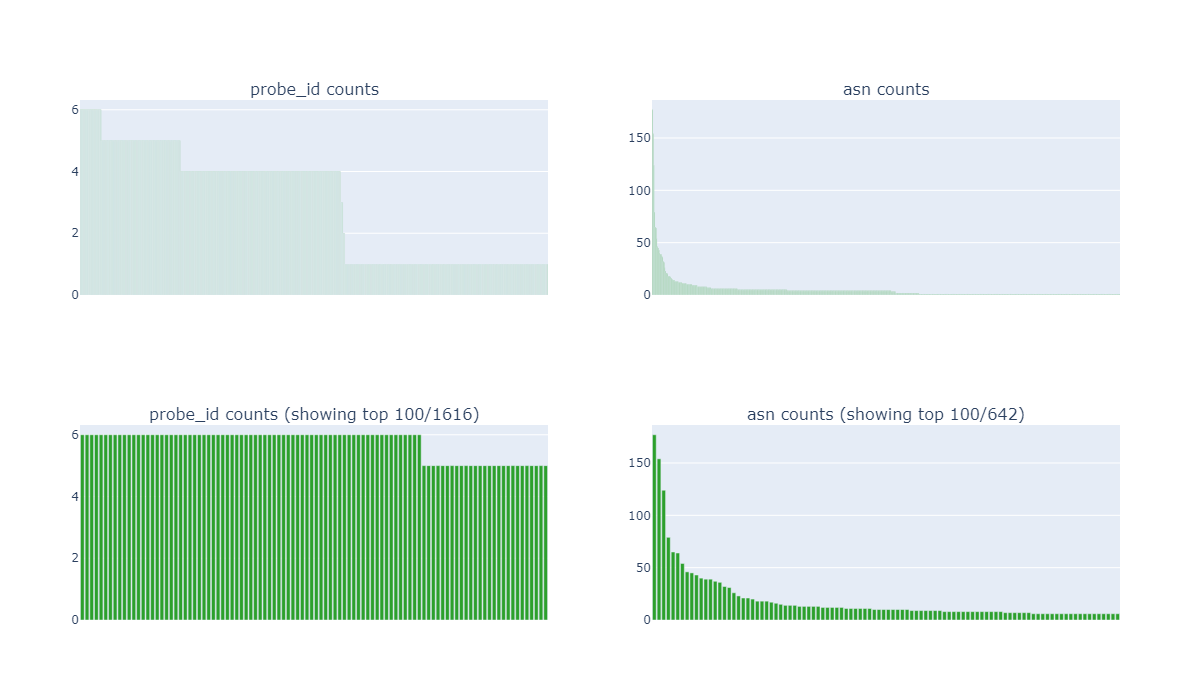

In [6]:
# How many of the top most frequent probes/ASNs to show
top_x_lines = 100 # Feel free to change this value!
# Specify if we want counts or frequencies (False for counts, True for frequencies)
normalize = False # Feel free to change this value!
# Create and plot the probe IDs and ASNs counts bar plots
probes_asns_counts_bar_traces = pu.get_probes_asns_counts_traces(probes_df, asns_df, top_x_lines = top_x_lines, normalize = normalize)
probes_asns_counts_fig = pu.get_probes_asns_counts_fig(probes_asns_counts_bar_traces)
probes_asns_counts_fig.show("png")

## 2 - Histograms of number of probes and asns used per measurement

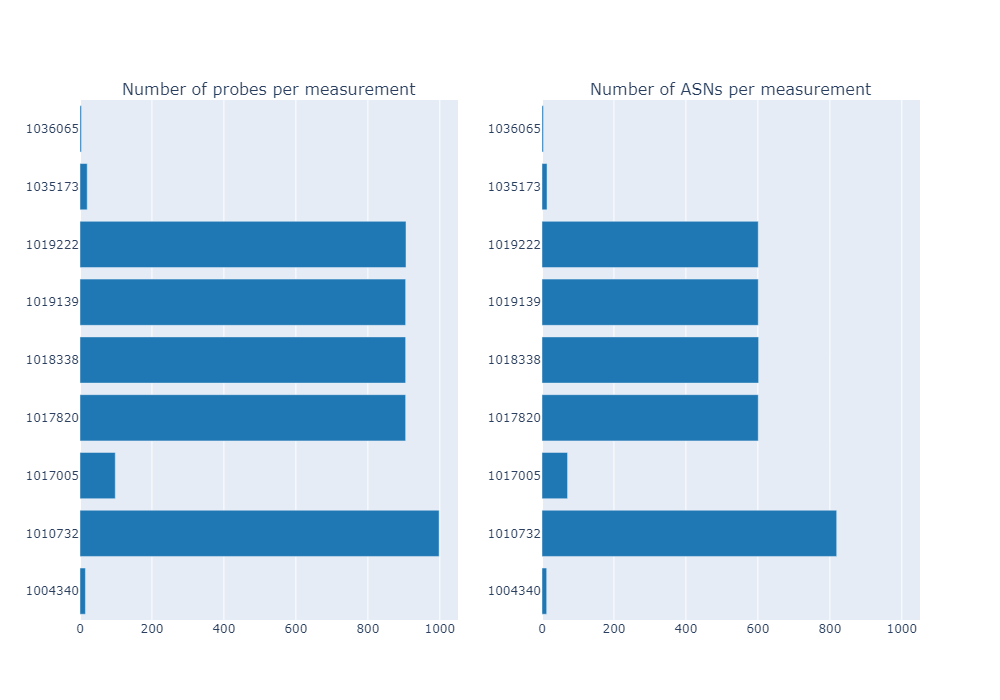

In [7]:
# Create and plot the number of probes/ASNs per measurement plots
num_probes_asns_per_meas_traces = pu.get_num_probes_asns_per_meas_traces(df)
num_probes_asns_per_meas_fig = pu.get_num_probes_asns_per_meas_fig(num_probes_asns_per_meas_traces)
num_probes_asns_per_meas_fig.show("png")

## 3 - Bias comparison: Measurements (average) vs random sample of probes

Here we first find the average number of probes $\hat{N}$ from all input measurements and then compare the average bias value of our input measurements with the average bias of a set of $\hat{N}$ randomly selected probes.

In [8]:
# Get data for the bias analysis plots
avg_bias_per_dim_data, avg_bias_data = adu.get_bias_analysis_data(df)

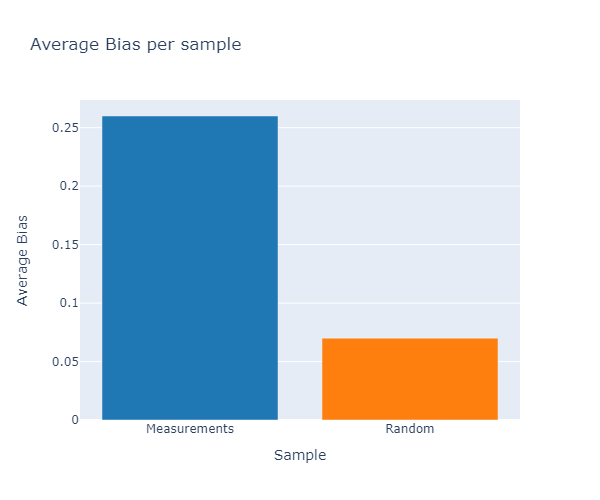

In [9]:
# Avg bias bar plot
average_bias_per_sample_trace = pu.get_average_bias_per_sample_trace(avg_bias_data)
average_bias_per_sample_fig = pu.get_average_bias_per_sample_fig(average_bias_per_sample_trace)
average_bias_per_sample_fig.show("png")

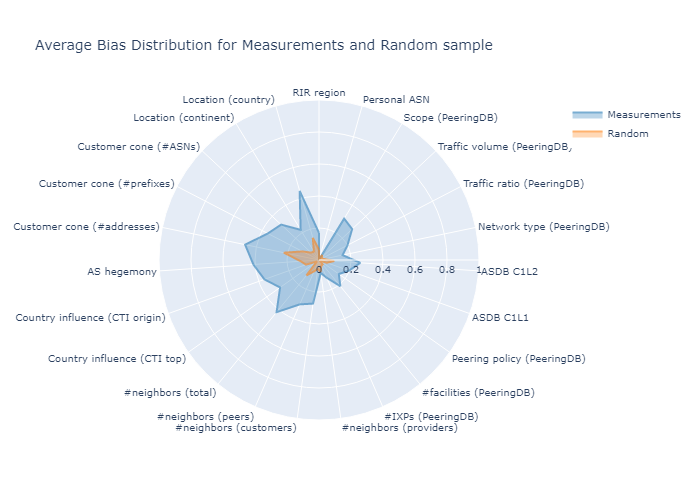

In [10]:
# Radar plot
avg_bias_per_dim_radar_traces = pu.get_radar_traces(avg_bias_per_dim_data)
avg_bias_per_dim_radar_fig = pu.get_avg_bias_per_dim_radar_fig(avg_bias_per_dim_radar_traces)
avg_bias_per_dim_radar_fig.show("png")

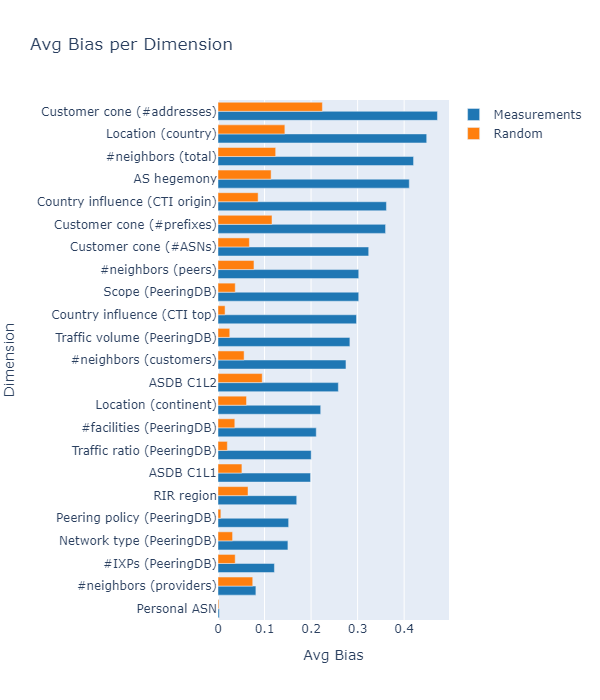

In [11]:
# Avg bias per dimension grouped bar plot
avg_bias_per_dim_bar_traces = pu.get_avg_bias_per_dim_bar_traces(avg_bias_per_dim_data)
avg_bias_per_dim_bar_fig = pu.get_avg_bias_per_dim_bar_fig(avg_bias_per_dim_bar_traces)
avg_bias_per_dim_bar_fig.show("png")

## 4 - Number of probes vs Avg Bias per measurement

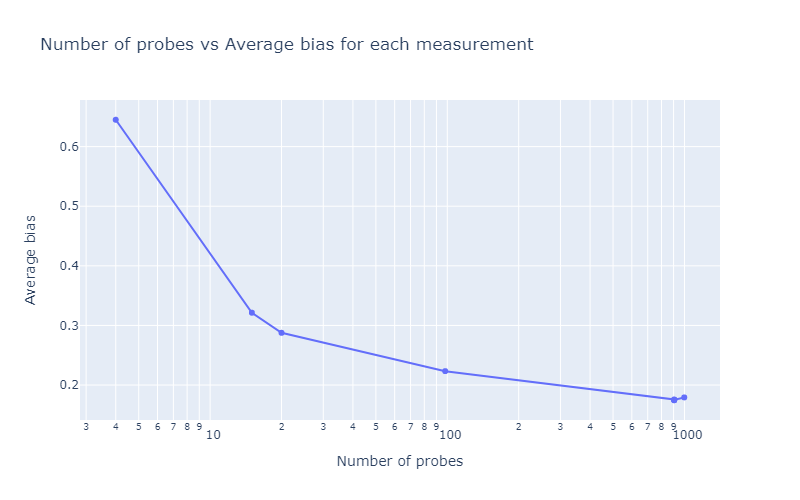

In [12]:
# Get and plot number of probes vs avg bias per measurement data
scatter_data = adu.get_num_probes_avg_bias_meas_scatter_df(df)
scatter_trace = pu.get_scatter_trace(scatter_data, 'num_probes', 'avg_meas_bias')
num_probes_avg_bias_meas_fig = pu.get_num_probes_avg_bias_meas_fig(scatter_trace)
num_probes_avg_bias_meas_fig.show("png")

## 5 - CDF of Bias per Bias dimension

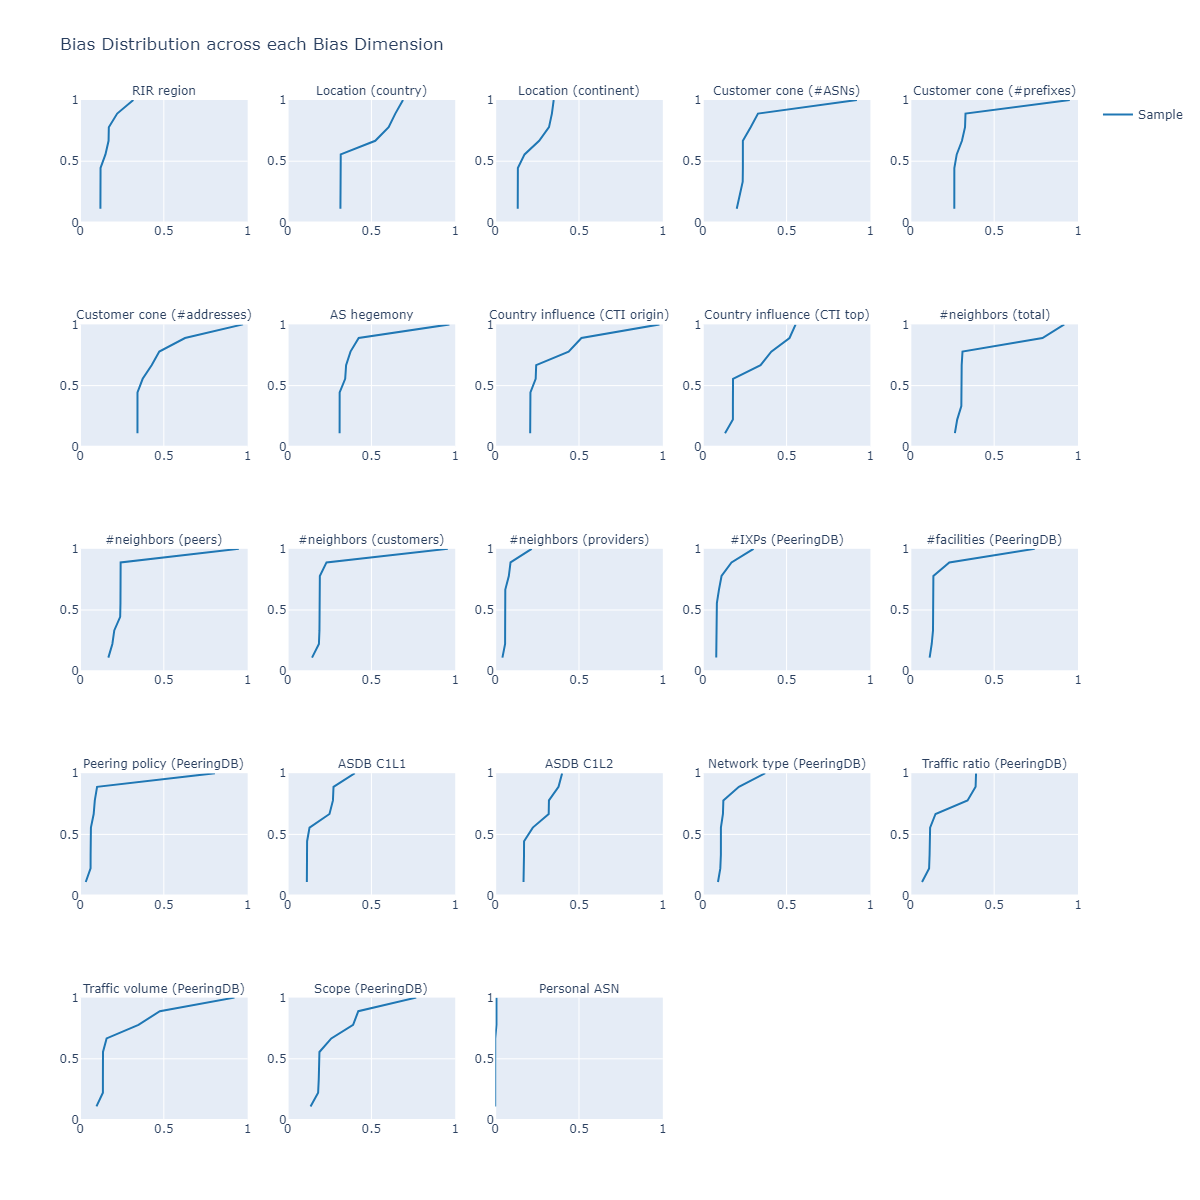

In [13]:
# Keep only bias dimensions
bias_df = df[BIAS_DIMENSIONS]
cdf_traces = pu.get_cdf_traces(bias_df)
cdfs_fig = pu.create_plot_grid(cdf_traces, one_plot_per_subplot=True)

# Show the plot
cdfs_fig.show("png")

## 6 - Bias Causes

In this section, we show the top `k` positive and negative bias causes for each measurement, as well as the top `k` (positive and negative) bias causes for the entire set of input measurements. The user can change the value of the `k`.

In [14]:
# Get and plot bias causes
k = 5 # Feel free to change this value
bias_causes_df, bias_causes_pivot_df = bc.bias_causes_main(input_meas_ids, asns_df, k = k)

Processing measurement with id 1018338.
1018338: Getting measurement's bias causes...


1018338: Got bias causes.
1018338: Time to get bias causes: 4.562
----------------------------------------------------------------------------------------------------
Processing measurement with id 1004340.
1004340: Getting measurement's bias causes...
1004340: Got bias causes.
1004340: Time to get bias causes: 4.693
----------------------------------------------------------------------------------------------------
Processing measurement with id 1017820.
1017820: Getting measurement's bias causes...
1017820: Got bias causes.
1017820: Time to get bias causes: 4.504
----------------------------------------------------------------------------------------------------
Processing measurement with id 1019139.
1019139: Getting measurement's bias causes...
1019139: Got bias causes.
1019139: Time to get bias causes: 4.505
----------------------------------------------------------------------------------------------------
Processing measurement with id 1017005.
1017005: Getting measurement's bia

In the cell below we show the first 15 of the bias causes for the first measurement from the input measurements, so that we can have a sense of how all the bias causes look.

In [15]:
# Bias causes of first input measurement
bias_causes_df[bias_causes_df['meas_id'] == str(input_meas_ids[0])].head(15)

,meas_id,bias_causes,value
0,1018338,Customer cone (#ASNs)_1.0-3.0,-68.9191
1,1018338,Customer cone (#ASNs)_3.0-9.0,16.5394
2,1018338,Customer cone (#ASNs)_9.0-26.0,11.9052
3,1018338,Customer cone (#ASNs)_26.0-76.0,10.0441
4,1018338,Customer cone (#ASNs)_76.0-222.0,7.5335
5,1018338,Customer cone (#ASNs)_222.0-654.0,3.0276
6,1018338,Customer cone (#ASNs)_654.0-1926.0,0.6319
7,1018338,Customer cone (#ASNs)_1926.0-5671.0,13.7680
8,1018338,Customer cone (#ASNs)_5671.0-16706.0,-0.0044
9,1018338,Customer cone (#ASNs)_16706.0-49213.0,5.4738


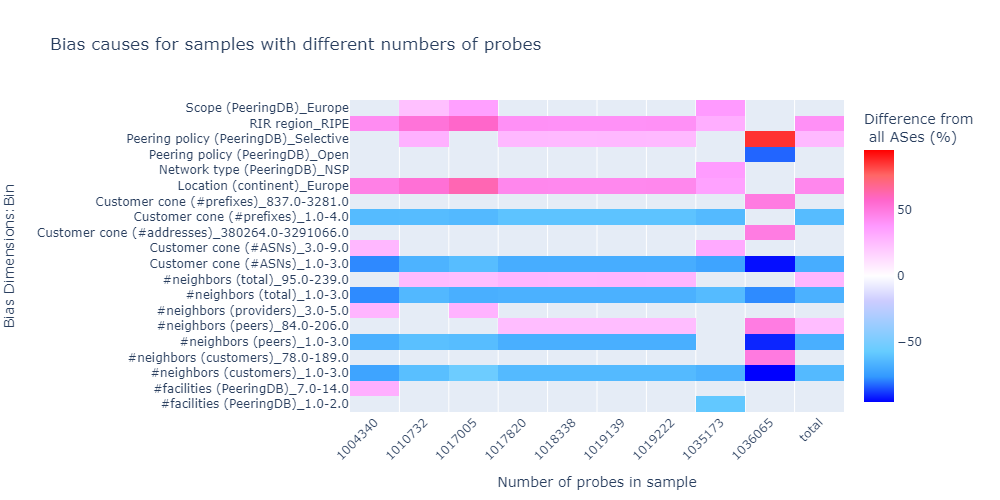

In [16]:
# Plot the bias causes heatmap
bias_causes_heatmap_trace = pu.get_bias_causes_heatmap_trace(bias_causes_pivot_df)
bias_causes_heatmap_fig = pu.get_bias_causes_heatmap_fig(bias_causes_heatmap_trace)
bias_causes_heatmap_fig.show("png")